In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re



from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier



import matplotlib.pyplot as plt


In [2]:
df_selftext = pd.read_csv('../../data/cleaned_selftext.csv')
df_notext = pd.read_csv('../../data/cleaned_notext.csv')
df_selftext.head(2)

,subreddit,text
0,0,using electric water boiler to mine bitcoin th...
1,0,btc to usdt hello i am looking to swap a good ...


In [3]:
print(df_selftext.subreddit.value_counts())
df_notext.subreddit.value_counts()

0    4017
1     787
Name: subreddit, dtype: int64


0    9938
1    2059
Name: subreddit, dtype: int64

# Adding stop words to not make it too easy

In [4]:
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik wa ha amp text would get llet like nt know one use think http'.split())


# Model

In [5]:
X = df_selftext.text
y = df_selftext.subreddit

In [6]:
y.value_counts(normalize=True)

0    0.836178
1    0.163822
Name: subreddit, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [8]:
# Pipeline accepts multiple transformers, but only one vectorizer. See cgpt results:

'''The error message is caused by the fact that you are trying to fit two different vectorizers (TfidfVectorizer and CountVectorizer) 
in the same pipeline, but only providing one input (X_train) to the pipeline. This is causing the pipeline to raise an error as it doesn't 
know which vectorizer to apply to the input. 

You can fix this by either removing one of the vectorizers or providing separate inputs to the pipeline for each vectorizer.'''


nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [9]:
nb_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [stop],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'nb__alpha': [.01, .05, .1, .25, .5, .1]
}

In [10]:
rs = RandomizedSearchCV(nb_pipe, 
                  nb_pipe_params, 
                    cv = 5) 

In [11]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                   param_distributions={'nb__alpha': [0.01, 0.05, 0.1, 0.25,
                                                      0.5, 0.1],
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', 

In [12]:
#using all stopwords lowers scores to 0.8823747680890538 / 0.8654060066740823

print(rs.score(X_train, y_train))
rs.score(X_test, y_test)

0.887316125451013


0.8701082431307244

In [13]:
rs.best_params_

{'tvec__stop_words': ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again'

In [14]:
rs.score(X_test, y_test)

0.8701082431307244

In [15]:
preds = rs.predict(X_test)

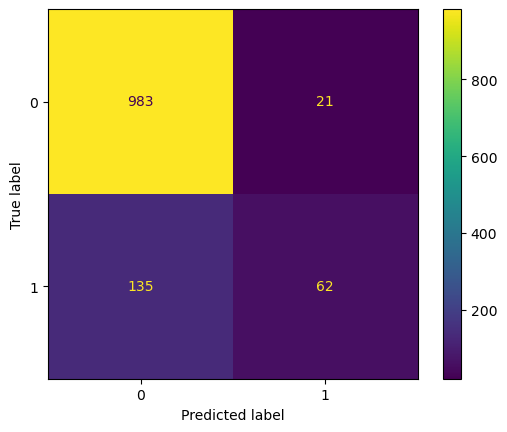

In [16]:
cm = confusion_matrix(y_test, preds)

display = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = rs.classes_)

display.plot();

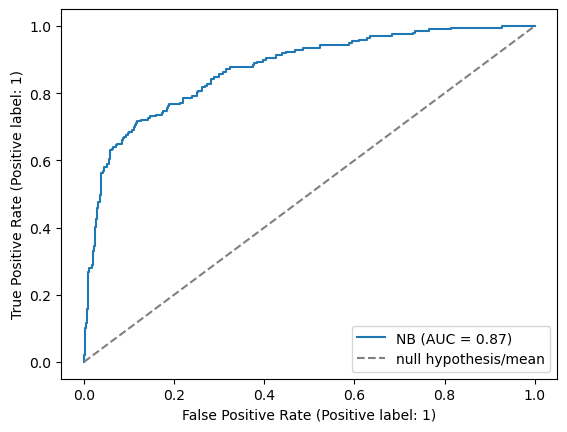

In [17]:
# Basic ROC

# cf ROC
# create an ax object
ax = plt.gca()

# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rs, X_test, y_test, ax=ax, name='NB')

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

# necessary to label the baseline
plt.legend();

# Preds analysis

In [18]:
pred_df = pd.DataFrame(rs.predict_proba(X_test),columns=['bitcoin', 'ethereum'])

pred_df['true_values'] = y_test.values

pred_df.head()


,bitcoin,ethereum,true_values
0,0.861358,0.138642,0
1,0.645317,0.354683,1
2,0.957978,0.042022,0
3,0.971335,0.028665,0
4,0.943089,0.056911,0


In [19]:
full_pred_df = pd.DataFrame(rs.predict_proba(X),columns=['bitcoin', 'ethereum'])

In [20]:
full_pred_df['true_values'] = y.values

full_pred_df.head()

,bitcoin,ethereum,true_values
0,0.981089,0.018911,0
1,0.977740,0.022260,0
2,0.946702,0.053298,0
3,0.960439,0.039561,0
4,0.975518,0.024482,0


In [21]:
df_selftext = df_selftext.join(full_pred_df)

In [22]:
df_selftext.sort_values(by = 'bitcoin')[0:100]

,subreddit,text,bitcoin,ethereum,true_values
4176,1,metamask hardcoded their privacy not friendly ...,0.003559,0.996441,1
4138,1,which design would you prefer if metamask is r...,0.004931,0.995069,1
4673,1,how to send my moon out of metamask into mexc ...,0.009964,0.990036,1
4621,1,fifacup win we are li on pinksale presale time...,0.015038,0.984962,1
4354,1,doe metamask not really know what token i own ...,0.017125,0.982875,1
...,...,...,...,...,...
4021,1,blockchain tech is here to stay and is shaping...,0.197185,0.802815,1
4637,1,hop protocol and bridge from polygon to mainne...,0.198205,0.801795,1
4598,1,how to handle moving your asset from a hacked ...,0.200537,0.799463,1
4029,1,how do you price an nft you created and offset...,0.202075,0.797925,1


# False Negatives

In [23]:
df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)].sort_values(by = 'bitcoin', ascending = False)

,subreddit,text,bitcoin,ethereum,true_values
4622,1,anyone else ner heard of ftx or sbf just got t...,0.986669,0.013331,1
4564,1,anywhere safe i can keep my eth till my ledger...,0.967288,0.032712,1
4236,1,if i can create an u bank account in china i w...,0.966480,0.033520,1
4647,1,would now be the time to buy and hold debating...,0.963239,0.036761,1
4645,1,what happens if trezor and ledger shut down wh...,0.960639,0.039361,1
...,...,...,...,...,...
4283,1,a new project to get your web app running and ...,0.511448,0.488552,1
4246,1,layer activity is ring up layer activity is ri...,0.511439,0.488561,1
4030,1,kzg ceremony li help scale ethereum month for ...,0.507447,0.492553,1
4413,1,balenciaga released their own nft for free for...,0.507044,0.492956,1


In [24]:
for i in df_selftext[(df_selftext.true_values == 1) & (df_selftext.bitcoin > .5)]['text']:
    print(i, '\n')

cannot enter into ethereum's discord trying to rify my account but interaction fails when clicking i tried to opening direct message and nothing 

ethereum network validators ha surged to a shanghai fer grows ethereum ha reached a new milestone in adoption and security a the number of validators on it network now exceeds according to data from beaconscan it s highlight the growing hype and confidence in the network a it gear up for the shanghai upgrade which will allow withdrawal of staked ether for the first time the increasing number of validators indicates that more and more individual and entity are willing to inst in the network and play a role in maintaining it integrity and security which is potentially a bullish sign for ethereum's price in the wake of the shanghai upgrade we can consider the security of the ethereum network on two ax one is the total value staked the other is the degree of decentralization said ben edgington ethereum deloper and lead product owner of ethereum 

# False Positives

In [25]:
bitcoinish_indexes = pred_df.loc[(pred_df['ethereum'] > .5) & (pred_df.true_values == 0)].index.values.astype(int)

In [26]:
for i in df_selftext.iloc[bitcoinish_indexes].text:
    print(i,'\n')

btc price during chinese new year doe anybody remember if chinese new year holiday ha affected bitcoin in the past a lot of money are changing hand during this time and i am wondering if this ha caused any uptrend in the past curious to hear your opinion 

not your key not your coin forbes article on binance's asset value loss in the last day are we about to see another major crash like the ftx affair i know a lot of bitcoiners are not really into mainstream medium narrati but what are your thought about the entuality of binance becoming the next ftx basing on this instigation by forbes s 

sold after keeping it for year before the price raise ended up sleeping in my car for a bit and really needed the money it wasn't much but it still hurt that i kept it for so long highest value i got to wa dollar that's a lot for me but had to pull out when it wa only worth suck but this is the end for me and i wish eryone else luck i t ha the fund to pour into bitcoin and it feel pointless anyways 

In [27]:
#notes
def class_from_prob(probabilities, threshold):

    return [0 if prob < threshold else 1 for prob in probabilities]


In [28]:
threshold_list = [round(i*.01,2) for i in range(0,101,)]
speclist = []
senslist = []
f1list = []

for threshold in threshold_list:
    predicted_classes = class_from_prob(pred_df['ethereum'], threshold)
    spec = specificity_score(y_test, predicted_classes)
    sens = recall_score(y_test, predicted_classes, pos_label=1)
    speclist.append(spec)
    senslist.append(sens)
    F1 = f1_score(y_test, predicted_classes)
    f1list.append(F1)

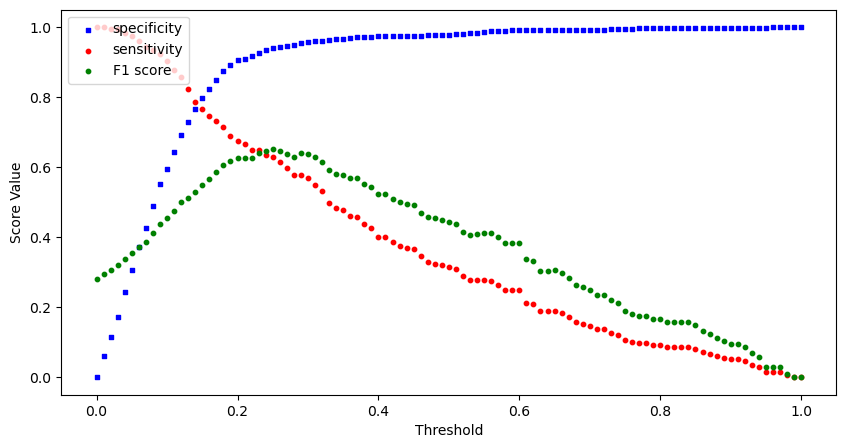

<Figure size 640x480 with 0 Axes>

In [29]:
%matplotlib inline
fig = plt.figure(figsize = (10,5));
ax1 = fig.add_subplot(111);

ax1.scatter(x = threshold_list, y = speclist, s=10, c='b', marker="s", label='specificity');
ax1.scatter(x = threshold_list,y = senslist, s=10, c='r', marker="o", label='sensitivity');
ax1.scatter(x = threshold_list,y = f1list, s=10, c='g', marker="o", label='F1 score');
plt.legend(loc='upper left')
plt.xlabel('Threshold');
plt.ylabel('Score Value');
plt.show();
plt.tight_layout();
